In [1]:
#NOTE: use paimg9 env
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction, BCE_Weighted_Reg, compute_loss_for_all_labels
from Model import Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
class Mutation_MIL_MT2(nn.Module):
    def __init__(self, in_features = 2048, act_func = 'tanh', drop_out = 0, n_outcomes = 7, dim_out = 128):
        super().__init__()
        self.in_features = in_features  
        self.n_outs = n_outcomes # number of outcomes
        self.d_out = dim_out   # dim of output layers
        self.drop_out = drop_out

        if act_func == 'leakyrelu':
            self.act_func = nn.LeakyReLU()
        if act_func == 'tanh':
            self.act_func = nn.Tanh()
        elif act_func == 'relu':
            self.act_func = nn.ReLU()

        self.embedding_layer = nn.Sequential(
            nn.Linear(self.in_features, 1024), #linear layer
            self.act_func,
            nn.Linear(1024, 512), #linear layer
            self.act_func,
            nn.Linear(512, 256), #linear layer
            self.act_func,
            nn.Linear(256, 128), #linear layer
        )

        #Outcome layers
        self.hidden_layers =  nn.ModuleList([nn.Linear(self.d_out, 1) for _ in range(self.n_outs)])        
        
        self.dropout = nn.Dropout(p=drop_out)

    def forward(self, x):
        r'''
        x size: [1, N_TILE ,N_FEATURE]
        '''
        
        #Linear
        x = self.embedding_layer(x) 
        x = torch.mean(x, dim=1) #avg on dim

        out = []
        for i in range(len(self.hidden_layers)):
            cur_out = self.hidden_layers[i](x)
            out.append(cur_out)

        #Drop out
        if self.drop_out > 0:
            for i in range(len(self.hidden_layers)):
                out[i] = self.dropout(out[i])
        
        # predict 
        for i in range(len(self.hidden_layers)):
            out[i] = torch.sigmoid(out[i])
        
        return out

In [3]:
####################################
######      USERINPUT       ########
####################################
SELECTED_MUTATION = "MT"
model_name = "MIL" #Chose from Linear, LinearMT
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
SELECTED_FEATURE = [str(i) for i in range(0,2048)] 
TUMOR_FRAC_THRES = 0
TRAIN_SAMPLE_SIZE = "ALL_TUMOR_TILES"
TRAIN_OVERLAP = 100
TEST_OVERLAP = 0
WITH_CLUSTER = True
WITH_TF = True


##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
train_tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TRAIN_OVERLAP) + '/'
test_tile_path =  proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL' + str(TEST_OVERLAP) + '/'
feature_name = 'features_alltiles_retccl'

# if WITH_CLUSTER == False:
#     model_data_path =  proj_dir + 'intermediate_data/model_ready_data/' + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '/'
# else:
#     model_data_path =  proj_dir + 'intermediate_data/model_ready_data/' + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + 'withCluster' + '/'
model_data_path = proj_dir + '/intermediate_data/model_ready_data/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0/split_fold0/'

################################################
#Create output-dir
################################################
if WITH_CLUSTER == False:
    outdir0 =  proj_dir + "intermediate_data/pred_out/" + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE)) + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '/'
else:
    outdir0 =  proj_dir + "intermediate_data/pred_out/" + 'MAX_SS'+ str(TRAIN_SAMPLE_SIZE) + '_NFEATURES2048_withTFandCLUSTER' + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + "_noAttention_" +'/'


outdir1 =  outdir0  + SELECTED_MUTATION + "/saved_model/" + model_name + "/"
outdir2 =  outdir0 + SELECTED_MUTATION + "/model_para/"
outdir3 =  outdir0 + SELECTED_MUTATION + "/logs/"
outdir4 =  outdir0 + SELECTED_MUTATION + "/predictions/"

create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0_noAttention_/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0_noAttention_/MT/saved_model/MIL/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0_noAttention_/MT/model_para/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0_noAttention_/MT/logs/' already exists.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/MAX_SSALL_TUMOR_TILES_NFEATURES2048_withTFandCLUSTER_TrainOL100_TestOL0_noAttention_/MT/predictions/' already exists.
cuda

In [4]:
################################################
#     Model ready data 
################################################
train_data = torch.load(model_data_path + 'train_data.pth')
test_data = torch.load(model_data_path + 'test_data.pth')
val_data = torch.load(model_data_path + 'val_data.pth')

train_ids = torch.load(model_data_path + 'train_ids.pth')
test_ids = torch.load(model_data_path + 'test_ids.pth')
test_info  = torch.load(model_data_path + 'test_info.pth')

In [5]:
####################################################
#            Train 
####################################################
set_seed(0)
LEARNING_RATE = 0.00001
BATCH_SIZE  = 1
ACCUM_SIZE = 16  # Number of steps to accumulate gradients
EPOCHS = 1000
DROPOUT = 0
DIM_OUT = 128
if WITH_CLUSTER == False and WITH_TF == False:
    N_FEATURE = len(SELECTED_FEATURE)
else:
    N_FEATURE = len(SELECTED_FEATURE) + 2
N_LABELS = len(SELECTED_LABEL)
LOSS_FUNC_NAME = "BCE_Weighted_Reg"
LOSS_WEIGHTS_LIST = [[1, 100], [1, 100], [1, 50], [1, 100], [1, 100], [1, 10], [1, 20]]  #NEG, POS
REG_COEEF = 0.001
REG_TYPE = 'L1'
OPTMIZER = "ADAM"
ATT_REG_FLAG = False


#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
def compute_loss_for_all_labels(predicted_list, target_list, weight_list, loss_func_name, loss_function, device, tumor_fractions, attention_scores):    
    loss_list = []
    for i in range(0,len(predicted_list)):
        if loss_func_name == "BCE_Weighted_Reg":
            if attention_scores is not None:
                cur_loss = loss_function(predicted_list[i],target_list[:,:,i].to(device),weight_list[i],tumor_fractions.squeeze().to(device), attention_scores.squeeze())
            else:
                cur_loss = loss_function(predicted_list[i],target_list[:,:,i].to(device),weight_list[i],tumor_fractions.squeeze().to(device), None)

        elif loss_func_name == "BCELoss": 
            cur_loss = loss_function(predicted_list[i],target_list[:,:,i].to(device), tumor_fractions.squeeze().to(device), attention_scores.squeeze()) 
        loss_list.append(cur_loss) #compute loss
    #Sum loss for all labels
    loss = sum(loss_list)

    return loss

Number of parameters: 2790151
Epoch0: Train-LOSS:311.35843, Valid-LOSS:275.27405
Epoch10: Train-LOSS:290.91306, Valid-LOSS:259.00831
Epoch20: Train-LOSS:260.50605, Valid-LOSS:241.46796
Epoch30: Train-LOSS:231.91234, Valid-LOSS:225.95230
Epoch40: Train-LOSS:215.36685, Valid-LOSS:213.51064
Epoch50: Train-LOSS:201.60793, Valid-LOSS:201.08930
Epoch60: Train-LOSS:188.76627, Valid-LOSS:188.78852
Epoch70: Train-LOSS:176.55511, Valid-LOSS:176.83753
Epoch80: Train-LOSS:164.90490, Valid-LOSS:165.33397
Epoch90: Train-LOSS:153.79783, Valid-LOSS:154.32085
Epoch100: Train-LOSS:143.22711, Valid-LOSS:143.81605
Epoch110: Train-LOSS:133.19306, Valid-LOSS:133.83121
Epoch120: Train-LOSS:123.69761, Valid-LOSS:124.37597
Epoch130: Train-LOSS:114.74662, Valid-LOSS:115.45793
Epoch140: Train-LOSS:106.34550, Valid-LOSS:107.08675
Epoch150: Train-LOSS:98.49981, Valid-LOSS:99.26793
Epoch160: Train-LOSS:91.21382, Valid-LOSS:92.00837
Epoch170: Train-LOSS:84.49233, Valid-LOSS:85.31337
Epoch180: Train-LOSS:78.33747, Va

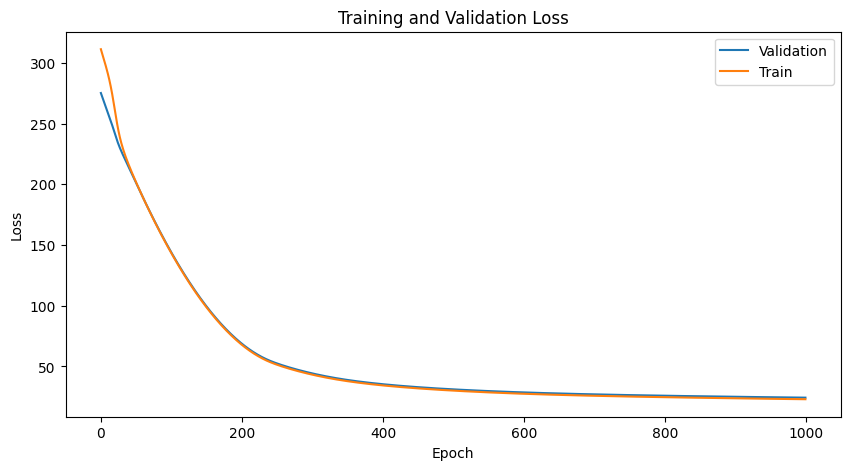

In [11]:
#Construct model
model = Mutation_MIL_MT2(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_LABELS,
                        dim_out = DIM_OUT)
model.to(device)

#Optimizer
if OPTMIZER == "ADAM":
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
elif OPTMIZER == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

#Loss
if LOSS_FUNC_NAME == "BCE_Weighted_Reg":
    loss_func = BCE_Weighted_Reg(REG_COEEF, REG_TYPE, model, reduction = 'mean', att_reg_flag = ATT_REG_FLAG)
elif LOSS_FUNC_NAME == "BCELoss":
    loss_func = torch.nn.BCELoss()
elif LOSS_FUNC_NAME == "BCE_Weighted_Reg_noATT":
    loss_func = BCE_Weighted_Reg(REG_COEEF, REG_TYPE, model, reduction = 'mean', att_reg_flag = ATT_REG_FLAG)
    
    

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                         "TRAIN_OVERLAP": TRAIN_OVERLAP,
                         "TEST_OVERLAP": TEST_OVERLAP,
                         "TRAIN_SAMPLE_SIZE": TRAIN_SAMPLE_SIZE,
                         "TUMOR_FRAC_THRES": TUMOR_FRAC_THRES,
                         "N_FEATURE": N_FEATURE,
                         "N_LABELS": N_LABELS,
                         "BATCH_SIZE": BATCH_SIZE,
                         "ACCUM_SIZE": ACCUM_SIZE,
                         "N_EPOCH": EPOCHS,
                         "OPTMIZER": OPTMIZER,
                         "LEARNING_RATE": LEARNING_RATE,
                         "DROPOUT": DROPOUT,
                         "DIM_OUT": DIM_OUT,
                         "REG_TYPE": REG_TYPE,
                         "REG_COEEF": REG_COEEF,
                         "LOSS_FUNC_NAME": LOSS_FUNC_NAME,
                         "LOSS_WEIGHTS_LIST": str(LOSS_WEIGHTS_LIST),
                         "ATT_REG_FLAG": ATT_REG_FLAG,
                         "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")


log_message("Start Training", outdir3 + "training_log.txt")


####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    ct = 0
    optmizer_loss = 0
    for x,y,tf in train_loader:
        ct += 1
        optimizer.zero_grad() #zero the grad
        yhat_list = model(x.to(device)) #Forward

        #compute loss
        train_att_list = None
        loss = compute_loss_for_all_labels(yhat_list, y, LOSS_WEIGHTS_LIST, LOSS_FUNC_NAME, loss_func, device, tf , train_att_list)

        running_loss += loss.detach().item() #acuumalated batch loss
        optmizer_loss += loss #accumalted loss for optimizer
       
        #Optimize
        if ct % ACCUM_SIZE == 0:
            optmizer_loss = optmizer_loss/ACCUM_SIZE
            optmizer_loss.backward() 
            optimizer.step()  # Optimize
            optmizer_loss = 0
            #optimizer.zero_grad() #gradient reset

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val,tf_val in val_loader:
            val_yhat_list  = model(x_val.to(device))
            val_att_list = None
            val_loss = compute_loss_for_all_labels(val_yhat_list, y_val, LOSS_WEIGHTS_LIST, LOSS_FUNC_NAME, loss_func, device, tf_val, val_att_list)
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)

    if epoch % 10 == 0:
        print("Epoch"+ str(epoch) + ":",
              "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
              "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir1 + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir1)
log_message("End Training", outdir3 + "training_log.txt")

#SAVE VALIDATION LOSS
valid_loss_df  = pd.DataFrame({"VALID_LOSS": valid_loss})
valid_loss_df.to_csv(outdir1 + "Valid_LOSS.csv")

In [10]:
####################################################################################
#Testing
####################################################################################
#Load model
# valid_loss_df = pd.read_csv(outdir1 + "Valid_LOSS.csv")
# min_index = valid_loss_df['VALID_LOSS'].idxmin()
# print(min_index)
min_index = 7
model2 = Mutation_MIL_MT2(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_LABELS,
                        dim_out = DIM_OUT)
state_dict = torch.load(outdir1 + "model" + str(min_index))

#model_dir = "/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/z_old_mutation_prediction_results/mutation_pred_out_11272024/MAX_SS0_NFEATURES2048/MT/saved_model/MIL/"
#state_dict = torch.load(model_dir + "model" + str(min_index))
model2.load_state_dict(state_dict)
model2.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.3

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction(test_loader, model2, N_LABELS, loss_func, device, attention = ATT_REG_FLAG)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
   pred_df_list.append(pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                          "Y_True": [l[i] for l in test_true_label], 
                                          "Pred_Prob" :  [l[i] for l in test_pred_prob],
                                          "OUTCOME": SELECTED_LABEL[i]}))
pred_df = pd.concat(pred_df_list)

#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir0 + SELECTED_MUTATION + "/pred_df.csv",index = False)


#Compute performance
perf_df = compute_performance_each_label(SELECTED_LABEL, pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir0 + SELECTED_MUTATION + "/perf.csv",index = True)

print(perf_df.iloc[:,[0,5,6,7,8,9]])
print("AVG AUC:", round(perf_df['AUC'].mean(),2))
print("AVG PRAUC:", round(perf_df['PR_AUC'].mean(),2))
#Use regularization no dropout now has the best performance at avg AUC = 0.61

Test-Loss TOTAL: 4.86225
               AUC  Recall  Precision  Specificity    PR_AUC  \
SAMPLE_LEVEL  0.59     1.0       0.12          0.0  0.339581   
SAMPLE_LEVEL  0.60     1.0       0.15          0.0  0.252169   
SAMPLE_LEVEL  0.33     1.0       0.22          0.0  0.180512   
SAMPLE_LEVEL  0.38     1.0       0.10          0.0  0.100938   
SAMPLE_LEVEL  0.54     1.0       0.40          0.0  0.474419   
SAMPLE_LEVEL  0.28     1.0       0.08          0.0  0.080222   
SAMPLE_LEVEL  0.56     1.0       0.08          0.0  0.152914   

                                                       OUTCOME  
SAMPLE_LEVEL                                                AR  
SAMPLE_LEVEL  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL                                              PTEN  
SAMPLE_LEVEL                                               RB1  
SAMPLE_LEVEL                                              TP53  
SAMPLE_LEVEL                           TMB_HIGHorINTERMEDITATE  
SAMPLE_

In [ ]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 100
mag_extract = 20
limit_bounds = True
TOP_K = 5
pretrain_model_name = "retccl"
mag_target_prob = 2.5
smooth = False
mag_target_tiss = 1.25

In [ ]:
i = 0
pt = test_ids[i]
print(pt)

save_location =  outdir4  + pt + "/"
create_dir_if_not_exists(save_location)

_file = wsi_path + pt + ".tif"
oslide = openslide.OpenSlide(_file)
save_name = str(Path(os.path.basename(_file)).with_suffix(''))


#Get a Attention, and corresponding tiles
cur_pt_att = test_att[i]
cur_pt_info = test_info[i]
cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)

In [ ]:
cur_pt_att

In [ ]:
#Generate tiles
tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)

#get level 0 size in px
l0_w = oslide.level_dimensions[0][0]
l0_h = oslide.level_dimensions[0][1]

#1.25x tissue detection for mask
from Utils import get_downsample_factor, get_image_at_target_mag
from Utils import do_mask_original,check_tissue,whitespace_check
import cv2
if 'OPX' in pt:
    rad_tissue = 5
elif '(2017-0133)' in pt:
    rad_tissue = 2
lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)

In [ ]:
#2.5x for probability maps
lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)

cur_att_df['pred_map_location'] = pd.NA
for index, row in cur_att_df.iterrows():
    cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
    x ,y = int(cur_xy[0]) , int(cur_xy[1])
    
    #Extract tile for prediction
    lvl_in_deepzoom = tile_lvls.index(mag_extract)
    tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
    map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
    cur_att_df.loc[index,'pred_map_location'] = str(tuple([map_xstart, map_xend, map_ystart, map_yend]))

    #Store predicted probabily in map and count
    try: 
        x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
        x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
    except:
        pass
    

In [ ]:
print('post-processing')
x_count = np.where(x_count < 1, 1, x_count)
x_map = x_map / x_count
x_map[x_map>1]=1

if smooth == True:
    x_sm = filters.gaussian(x_map, sigma=2)
if smooth == False:
    x_sm = x_map

he_mask = cv2.resize(np.uint8(he_mask),(x_sm.shape[1],x_sm.shape[0])) #resize to output image size
#TODO:
#get cancer_mask:
# cancer_mask == 
# x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
x_sm[he_mask < 1] = 0.001 

plt.imshow(x_sm, cmap='Spectral_r')
plt.colorbar()
#plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
#Top attented tiles
save_location2 = save_location + "top_tiles/"
create_dir_if_not_exists(save_location2)

#Get a Attention, and corresponding tiles
cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)

for i in range(TOP_K):
    cur_pulled_img = cur_pulled_img_obj[i][0] #image
    cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
    cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
    coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
    tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
    cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

#Bot attented tiles
save_location2 = save_location + "bot_tiles/"
create_dir_if_not_exists(save_location2)

#Get a Attention, and corresponding tiles
cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)

for i in range(TOP_K):
    cur_pulled_img = cur_pulled_img_obj[i][0] #image
    cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
    cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
    coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
    tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
    cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

In [ ]:
#TODO LIST
#1.Attention score
#2. zero gradiant place

In [ ]:
# Define the parameters
import torch.nn as nn
import torch
embed_dim = 128  # Embedding dimension
num_heads = 1   # Number of attention heads

# Create an instance of the MultiheadAttention module
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first = True)

In [ ]:
embedding_layer = nn.Sequential(
    nn.Linear(2048, 1024), #linear layer
    nn.Tanh(),
    nn.Linear(1024, 512), #linear layer
    nn.Tanh(),
    nn.Linear(512, 256), #linear layer
    nn.Tanh(),
    nn.Linear(256, 128), #linear layer
)

In [ ]:
x = torch.rand(1, 3, 2048)
r = embedding_layer(x)
r.shape

attn_output, attn_output_weights = multihead_attn(r, r, r)

In [ ]:
attn_output_weights